# Visualisation of equilibrium states

In this notebook we visualise different initial states and the final states relaxed with the LLG equation using the results of Fidimag simulations. To do this we load corresponding `npy` files that contain the magnetisation profile of a simulation, i.e. the spin orientations. 
To find the isosurfaces we use the marching cubes algorithm from SciKit image and colour the surfaces according to the in-plane orientation of the spins (using the conventional HSL colour space). To colour the surface elements we interpolate the spin orientations in the 3D space using scipy interpolate and then we find the center of the triangles from the marching cubes result. We then use these centers to find the spin orientations and then convert them to the HSL colour using OOMMFPY's tools.

In [1]:
# %%
import sys
import plot_tools as pt
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import matplotlib as mpl
import numpy as np
from skimage import measure

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from scipy.spatial import ConvexHull
import scipy.interpolate as si
from matplotlib.colors import LightSource
import oommfpy.tools as ot

from pathlib import Path
import glob

In [2]:
import fidimag as fd
from fidimag.common import CuboidMesh
from fidimag.atomistic import Sim

# Define a Fidimag simulation

We define a Fidimag simulation with 30x30x30 spins to load the `npy` files of the NEBM simulations and visualise them:

In [3]:
FIELD = 100
nx, ny, nz = 30, 30, 30
dx, dy, dz = 1, 1, 1
mesh = CuboidMesh(nx=nx, ny=ny, nz=nz,
                  dx=dx, dy=dy, dz=dz,
                  x0=-nx * 0.5, y0=-ny * 0.5, z0=-nz * 0.5,
                  unit_length=1.,
                  periodicity=(True, True, False)
                  )
x, y, z = mesh.coordinates[:, 0], mesh.coordinates[:, 1], mesh.coordinates[:, 2]
xs, ys, zs = np.unique(x), np.unique(y), np.unique(z)

sim_name = 'sk_helix'
sim = Sim(mesh, name=sim_name, integrator='sundials_openmp')

sim.mu_s = 1
sim.add(fd.atomistic.Exchange(1))
sim.add(fd.atomistic.DMI(0.727, dmi_type='bulk'))
bz_min = FIELD
sim.add(fd.atomistic.Zeeman((0.0, 0.0, bz_min * 1e-3)), save_field=True)
kc = 0.00
if np.abs(kc) > 0.0:
    sim.add(fd.atomistic.CubicAnisotropy(kc))

Number of threads (CVODE) = 8


# Skyrmion tube

Here we plot a skyrmion tube using SciKit's marching cubes algorithm to find the iso-surface $s_z=0$

In [4]:
SIM_PATH = Path('sims/fidimag/equilibrium_states/cubic_anisotropy/npys/')
INIT_PATH = Path('sims/fidimag/equilibrium_states/D727e-3/npys/')

In [9]:
spins = []

# sim.set_m(np.load(GNEBM_PATH / f'sk_tube_INIT/m_sk_tube_INIT_Bz_000400.npy'))
sim.set_m(np.load(SIM_PATH / f'sk_tube_kc-5e-2/m_sk_tube_kc-5e-2_Bz_000400.npy'))

sp_copy = np.copy(sim.spin.reshape(-1, 3))
spins.append(sp_copy)

<ipython-input-10-4422d2db82c2>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = f.add_subplot(f'111', projection='3d', proj_type='ortho')


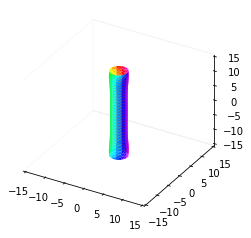

In [10]:
# ax = f.add_subplot(f'13{i + 1}', projection='3d', proj_type = 'ortho')
# ax.set_p

sp_idx = 0
f = plt.figure()
ax = f.add_subplot(f'111', projection='3d', proj_type='ortho')

vol_mz = spins[sp_idx][:, 2].reshape(nx, ny, nz)
verts, faces, normals, values = measure.marching_cubes(vol_mz.T, 0., 
                                                       spacing=(1, 1, 1))

verts -= 14.5
p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                    triangles=faces,
                    # cannot control color point-wise in trisurf:  
                    color='red',
                    # cmap='RdYlBu', 
                    lw=1, vmin=-1, vmax=1
                    )

# Interpolate the spin orientations to colour the isosurface elements
vol_mx = spins[sp_idx][:, 0].reshape(nx, ny, nz).T
data_interp_x = si.RegularGridInterpolator((xs, ys, zs), vol_mx)
vol_my = spins[sp_idx][:, 1].reshape(nx, ny, nz).T
data_interp_y = si.RegularGridInterpolator((xs, ys, zs), vol_my)
vol_mz = spins[sp_idx][:, 2].reshape(nx, ny, nz).T
data_interp_z = si.RegularGridInterpolator((xs, ys, zs), vol_mz)

# Find the triangle centers from the marching cube elements
tri_centres = np.mean(verts[faces], axis=1)
# colors = mpl.cm.RdBu(data_interp(tri_centres))
# print('tcs', tri_centres.shape)
m_interp = np.column_stack((data_interp_x(tri_centres),
                            data_interp_y(tri_centres),
                            data_interp_z(tri_centres)))
# print('ms', m_interp.shape)
# Use oommfpy tools to convert the spin orientations to a HSL colour
colors = ot.generate_colours(m_interp)
p._facecolors2d = p._facecolors3d
p.set_facecolors(colors)

# ax.add_collection3d(col)

ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15])
ax.set_zlim([-15, 15])

# Get rid of colored axes planes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)

plt.savefig('sk_tube_Bz400_relaxed.pdf', bbox_inches='tight')

In [11]:
spins = []

sim.set_m(np.load(INIT_PATH / f'sk_tube_INIT/m_sk_tube_INIT_Bz_000400.npy'))

sp_copy = np.copy(sim.spin.reshape(-1, 3))
spins.append(sp_copy)

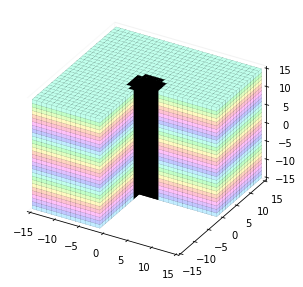

In [12]:
# ax = f.add_subplot(f'13{i + 1}', projection='3d', proj_type = 'ortho')
# ax.set_p

spin = spins[0]
f = plt.figure(figsize=(5, 5))
ax = f.add_subplot(1, 1, 1, projection='3d', 
                   proj_type='ortho'
                   )

ftr = np.logical_or(y > -1, x < -1)
ls = LightSource(azdeg=65, altdeg=10)
m_data = np.column_stack((spin[:, 0][ftr], 
                          spin[:, 1][ftr], 
                          spin[:, 2][ftr]))
col= pt.plotCubeAt(mesh.coordinates[ftr],
                   np.tile(np.array([1., 1., 1.]), 
                           len(mesh.coordinates[ftr])).reshape(-1, 3),
                   edgecolor="k", linewidth=.05,
                   # facecolor='C0', alpha=0.1,
                   # colors=mpl.cm.RdBu(data_interp(coords[ftr])),
                   # colors=mpl.cm.RdBu(spin[:, 2][ftr]),
                   colors=ot.generate_colours(m_data)
                   # lightsource=True
                   # lightsource=ls
                   )


# new_cs = ax._shade_colors(cs, ns, ls)
# col.set_facecolors(new_cs)
ax.add_collection3d(col)

ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15])
ax.set_zlim([-15, 15])

# Get rid of colored axes planes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)

plt.savefig('sk_tube_Bz400_cuboids_init.pdf', bbox_inches='tight')

In [14]:
spins = []

for s in [INIT_PATH / 'sk_tube_INIT/m_sk_tube_INIT_Bz_000400.npy',
          SIM_PATH / 'sk_tube_kc-5e-2/m_sk_tube_kc-5e-2_Bz_000400.npy']:
    sim.set_m(np.load(f'{s}'))
    sp_copy = np.copy(sim.spin.reshape(-1, 3))
    spins.append(sp_copy)

In [64]:
spins[sp_idx]

array([[ 0.32233598, -0.10647799,  0.94061786],
       [ 0.32272009, -0.10625126,  0.94051178],
       [ 0.32249072, -0.10610542,  0.94060692],
       ...,
       [ 0.32334104,  0.10564619,  0.94036666],
       [ 0.32368962,  0.10535892,  0.94027896],
       [ 0.32345954,  0.1050995 ,  0.94038717]])

In [65]:
spins[i]

array([[ 0.32233598, -0.10647799,  0.94061786],
       [ 0.32272009, -0.10625126,  0.94051178],
       [ 0.32249072, -0.10610542,  0.94060692],
       ...,
       [ 0.32334104,  0.10564619,  0.94036666],
       [ 0.32368962,  0.10535892,  0.94027896],
       [ 0.32345954,  0.1050995 ,  0.94038717]])

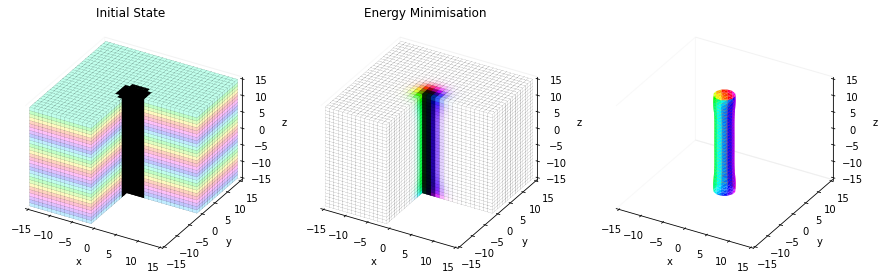

In [15]:
# ax = f.add_subplot(f'13{i + 1}', projection='3d', proj_type = 'ortho')
# ax.set_p

f = plt.figure(figsize=(15, 5))

for i in range(2):
    spin = spins[i]
    ax = f.add_subplot(1, 3, i  + 1, projection='3d', 
                       proj_type='ortho'
                       )
    
    ftr = np.logical_or(y > -1, x < -1)
    ls = LightSource(azdeg=65, altdeg=10)
    m_data = np.column_stack((spin[:, 0][ftr], 
                              spin[:, 1][ftr], 
                              spin[:, 2][ftr]))
    col= pt.plotCubeAt(mesh.coordinates[ftr],
                       np.tile(np.array([1., 1., 1.]), 
                               len(mesh.coordinates[ftr])).reshape(-1, 3),
                       edgecolor="k", linewidth=.05,
                       # facecolor='C0', alpha=0.1,
                       # colors=mpl.cm.RdBu(data_interp(coords[ftr])),
                       # colors=mpl.cm.RdBu(spin[:, 2][ftr]),
                       colors=ot.generate_colours(m_data)
                       # lightsource=True
                       # lightsource=ls
                       )
    ax.add_collection3d(col)
    
# ----------------------------------------------------------------------------
# Sk tube surface
ax = f.add_subplot(1, 3, 3, projection='3d', proj_type='ortho')

i = 1
vol_mz = spins[i][:, 2].reshape(nx, ny, nz)
verts, faces, normals, values = measure.marching_cubes(vol_mz.T, 0., 
                                                       spacing=(1, 1, 1))
verts -= 14.5
p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                    triangles=faces,
                    # cannot control color point-wise in trisurf:  
                    color='red',
                    # cmap='RdYlBu', 
                    lw=1, vmin=-1, vmax=1
                    )
# print(p._facecolors3d.shape)
vol_mx = spins[i][:, 0].reshape(nx, ny, nz).T
data_interp_x = si.RegularGridInterpolator((xs, ys, zs), vol_mx)
vol_my = spins[i][:, 1].reshape(nx, ny, nz).T
data_interp_y = si.RegularGridInterpolator((xs, ys, zs), vol_my)
vol_mz = spins[i][:, 2].reshape(nx, ny, nz).T
data_interp_z = si.RegularGridInterpolator((xs, ys, zs), vol_mz)

tri_centres = np.mean(verts[faces], axis=1)
# colors = mpl.cm.RdBu(data_interp(tri_centres))
# print('tcs', tri_centres.shape)
m_interp = np.column_stack((data_interp_x(tri_centres),
                            data_interp_y(tri_centres),
                            data_interp_z(tri_centres)))
# print('ms', m_interp.shape)
colors = ot.generate_colours(m_interp)
p._facecolors2d = p._facecolors3d
p.set_facecolors(colors)

for ax in f.get_axes():
    ax.set_xlim([-15, 15])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-15, 15])

    # Get rid of colored axes planes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# ----------------------------------------------------------------------------

titles = ['Initial State', 'Energy Minimisation']
for i in range(2):
    ax = f.get_axes()[i]
    ax.set_title(titles[i])
    
# plt.savefig('sk_tube_Bz400_cuboids_minimisation.pdf', bbox_inches='tight')
plt.savefig('sk_tube_Bz400_cuboids_minimisation.jpg', dpi=200,
            bbox_inches='tight')

## As a function of field

In [17]:
spins = []

for s in [SIM_PATH / f'sk_tube_kc-5e-2/m_sk_tube_kc-5e-2_Bz_000{i:03d}.npy' 
          for i in [280, 340, 400, 460, 500]]:
    sim.set_m(np.load(f'{s}'))
    sp_copy = np.copy(sim.spin.reshape(-1, 3))
    spins.append(sp_copy)

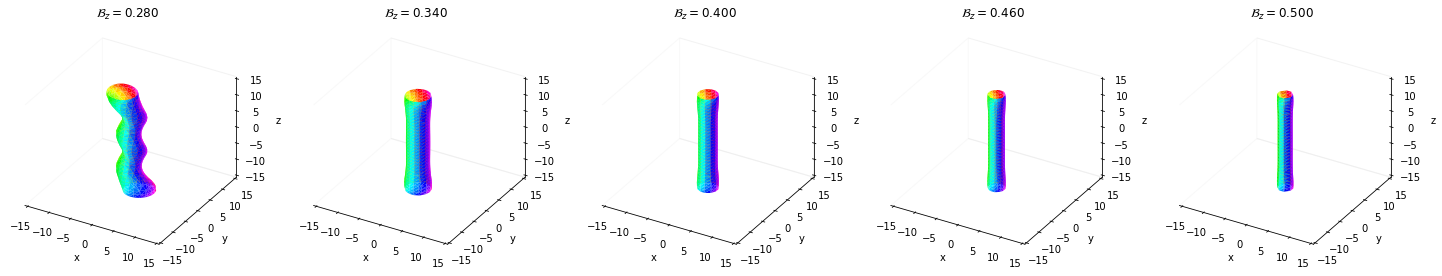

In [21]:
# ax = f.add_subplot(f'13{i + 1}', projection='3d', proj_type = 'ortho')
# ax.set_p

f = plt.figure(figsize=(25, 5))

titles = [280, 340, 400, 460, 500]
for i in range(5):

    # Sk tube surface
    ax = f.add_subplot(1, 5, i + 1, projection='3d', proj_type='ortho')

    vol_mz = spins[i][:, 2].reshape(nx, ny, nz)
    verts, faces, normals, values = measure.marching_cubes(vol_mz.T, 0., 
                                                           spacing=(1, 1, 1))
    verts -= 14.5
    p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                        triangles=faces,
                        # cannot control color point-wise in trisurf:  
                        color='red',
                        # cmap='RdYlBu', 
                        lw=1, vmin=-1, vmax=1
                        )
    # print(p._facecolors3d.shape)
    vol_mx = spins[i][:, 0].reshape(nx, ny, nz).T
    data_interp_x = si.RegularGridInterpolator((xs, ys, zs), vol_mx)
    vol_my = spins[i][:, 1].reshape(nx, ny, nz).T
    data_interp_y = si.RegularGridInterpolator((xs, ys, zs), vol_my)
    vol_mz = spins[i][:, 2].reshape(nx, ny, nz).T
    data_interp_z = si.RegularGridInterpolator((xs, ys, zs), vol_mz)

    tri_centres = np.mean(verts[faces], axis=1)
    # colors = mpl.cm.RdBu(data_interp(tri_centres))
    # print('tcs', tri_centres.shape)
    m_interp = np.column_stack((data_interp_x(tri_centres),
                                data_interp_y(tri_centres),
                                data_interp_z(tri_centres)))
    # print('ms', m_interp.shape)
    colors = ot.generate_colours(m_interp)
    p._facecolors2d = p._facecolors3d
    p.set_facecolors(colors)
    
    ax.set_title(r'$\mathcal{B}_{z}=$' + f'{titles[i] * 1e-3:.3f}')

for ax in f.get_axes():
    ax.set_xlim([-15, 15])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-15, 15])

    # Get rid of colored axes planes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# ----------------------------------------------------------------------------
    
# plt.savefig('sk_tube_Bz400_cuboids_minimisation.pdf', bbox_inches='tight')
plt.savefig('sk_tubes_vs_field_anisotropy.jpg', dpi=200,
            bbox_inches='tight')

# Skyrmion tube - No Anisotropy

In [5]:
SIM_PATH = Path('sims/fidimag/equilibrium_states/D727e-3/npys/')
INIT_PATH = Path('sims/fidimag/equilibrium_states/D727e-3/npys/')

In [28]:
spins = []

# sim.set_m(np.load(GNEBM_PATH / f'sk_tube_INIT/m_sk_tube_INIT_Bz_000400.npy'))
sim.set_m(np.load(SIM_PATH / f'sk_tube/m_sk_tube_Bz_000400.npy'))

sp_copy = np.copy(sim.spin.reshape(-1, 3))
spins.append(sp_copy)

<ipython-input-24-f4a770849d38>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = f.add_subplot(f'111', projection='3d', proj_type='ortho')


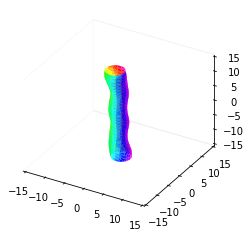

In [24]:
# ax = f.add_subplot(f'13{i + 1}', projection='3d', proj_type = 'ortho')
# ax.set_p

sp_idx = 0
f = plt.figure()
ax = f.add_subplot(f'111', projection='3d', proj_type='ortho')

vol_mz = spins[sp_idx][:, 2].reshape(nx, ny, nz)
verts, faces, normals, values = measure.marching_cubes(vol_mz.T, 0., 
                                                       spacing=(1, 1, 1))

verts -= 14.5
p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                    triangles=faces,
                    # cannot control color point-wise in trisurf:  
                    color='red',
                    # cmap='RdYlBu', 
                    lw=1, vmin=-1, vmax=1
                    )
# print(p._facecolors3d.shape)
vol_mx = spins[sp_idx][:, 0].reshape(nx, ny, nz).T
data_interp_x = si.RegularGridInterpolator((xs, ys, zs), vol_mx)
vol_my = spins[sp_idx][:, 1].reshape(nx, ny, nz).T
data_interp_y = si.RegularGridInterpolator((xs, ys, zs), vol_my)
vol_mz = spins[sp_idx][:, 2].reshape(nx, ny, nz).T
data_interp_z = si.RegularGridInterpolator((xs, ys, zs), vol_mz)

tri_centres = np.mean(verts[faces], axis=1)
# colors = mpl.cm.RdBu(data_interp(tri_centres))
# print('tcs', tri_centres.shape)
m_interp = np.column_stack((data_interp_x(tri_centres),
                            data_interp_y(tri_centres),
                            data_interp_z(tri_centres)))
# print('ms', m_interp.shape)
colors = ot.generate_colours(m_interp)
p._facecolors2d = p._facecolors3d
p.set_facecolors(colors)

# ax.add_collection3d(col)

ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15])
ax.set_zlim([-15, 15])

# Get rid of colored axes planes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)

plt.savefig('sk_tube_Bz400_no-anis_relaxed.pdf', bbox_inches='tight')

In [29]:
spins = []

# sim.set_m(np.load(GNEBM_PATH / f'sk_tube_INIT/m_sk_tube_INIT_Bz_000400.npy'))
sim.set_m(np.load(SIM_PATH / f'sk_tube/m_sk_tube_Bz_000300.npy'))

sp_copy = np.copy(sim.spin.reshape(-1, 3))
spins.append(sp_copy)

<ipython-input-30-0026fa419283>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = f.add_subplot(f'111', projection='3d', proj_type='ortho')


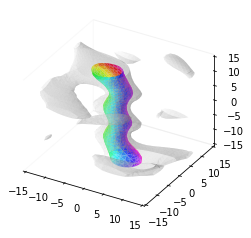

In [30]:
# ax = f.add_subplot(f'13{i + 1}', projection='3d', proj_type = 'ortho')
# ax.set_p

sp_idx = 0
f = plt.figure()
ax = f.add_subplot(f'111', projection='3d', proj_type='ortho')

vol_mz = spins[sp_idx][:, 2].reshape(nx, ny, nz)
verts, faces, normals, values = measure.marching_cubes(vol_mz.T, 0., 
                                                       spacing=(1, 1, 1))

verts -= 14.5
p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                    triangles=faces,
                    # cannot control color point-wise in trisurf:  
                    color='red',
                    # cmap='RdYlBu', 
                    lw=1, vmin=-1, vmax=1
                    )
# print(p._facecolors3d.shape)
vol_mx = spins[sp_idx][:, 0].reshape(nx, ny, nz).T
data_interp_x = si.RegularGridInterpolator((xs, ys, zs), vol_mx)
vol_my = spins[sp_idx][:, 1].reshape(nx, ny, nz).T
data_interp_y = si.RegularGridInterpolator((xs, ys, zs), vol_my)
vol_mz = spins[sp_idx][:, 2].reshape(nx, ny, nz).T
data_interp_z = si.RegularGridInterpolator((xs, ys, zs), vol_mz)

tri_centres = np.mean(verts[faces], axis=1)
# colors = mpl.cm.RdBu(data_interp(tri_centres))
# print('tcs', tri_centres.shape)
m_interp = np.column_stack((data_interp_x(tri_centres),
                            data_interp_y(tri_centres),
                            data_interp_z(tri_centres)))
# print('ms', m_interp.shape)
colors = ot.generate_colours(m_interp)
p._facecolors2d = p._facecolors3d
p.set_facecolors(colors)

# ----------------------------------------------------------------------------
vol_mz = spins[sp_idx][:, 2].reshape(nx, ny, nz)
verts, faces, normals, values = measure.marching_cubes(vol_mz.T, 0.58, 
                                                       spacing=(1, 1, 1))

verts -= 14.5
p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                    triangles=faces,
                    # cannot control color point-wise in trisurf:  
                    color='w',
                    # cmap='RdYlBu', 
                    lw=1, vmin=-1, vmax=1, alpha=0.3
                    )

# ax.add_collection3d(col)

ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15])
ax.set_zlim([-15, 15])

# Get rid of colored axes planes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)

# plt.savefig('sk_tube_Bz400_no-anis_relaxed.pdf', bbox_inches='tight')

In [25]:
spins = []

for s in [INIT_PATH / 'sk_tube_INIT/m_sk_tube_INIT_Bz_000400.npy',
          SIM_PATH / 'sk_tube/m_sk_tube_Bz_000400.npy']:
    sim.set_m(np.load(f'{s}'))
    sp_copy = np.copy(sim.spin.reshape(-1, 3))
    spins.append(sp_copy)

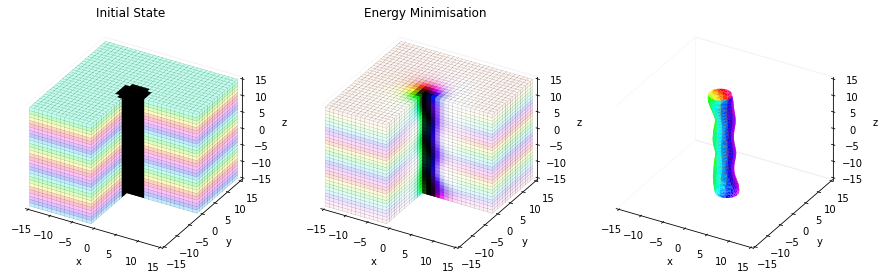

In [26]:
# ax = f.add_subplot(f'13{i + 1}', projection='3d', proj_type = 'ortho')
# ax.set_p

f = plt.figure(figsize=(15, 5))

for i in range(2):
    spin = spins[i]
    ax = f.add_subplot(1, 3, i  + 1, projection='3d', 
                       proj_type='ortho'
                       )
    
    ftr = np.logical_or(y > -1, x < -1)
    ls = LightSource(azdeg=65, altdeg=10)
    m_data = np.column_stack((spin[:, 0][ftr], 
                              spin[:, 1][ftr], 
                              spin[:, 2][ftr]))
    col= pt.plotCubeAt(mesh.coordinates[ftr],
                       np.tile(np.array([1., 1., 1.]), 
                               len(mesh.coordinates[ftr])).reshape(-1, 3),
                       edgecolor="k", linewidth=.05,
                       # facecolor='C0', alpha=0.1,
                       # colors=mpl.cm.RdBu(data_interp(coords[ftr])),
                       # colors=mpl.cm.RdBu(spin[:, 2][ftr]),
                       colors=ot.generate_colours(m_data)
                       # lightsource=True
                       # lightsource=ls
                       )
    ax.add_collection3d(col)
    
# ----------------------------------------------------------------------------
# Sk tube surface
ax = f.add_subplot(1, 3, 3, projection='3d', proj_type='ortho')

i = 1
vol_mz = spins[i][:, 2].reshape(nx, ny, nz)
verts, faces, normals, values = measure.marching_cubes(vol_mz.T, 0., 
                                                       spacing=(1, 1, 1))
verts -= 14.5
p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                    triangles=faces,
                    # cannot control color point-wise in trisurf:  
                    color='red',
                    # cmap='RdYlBu', 
                    lw=1, vmin=-1, vmax=1
                    )
# print(p._facecolors3d.shape)
vol_mx = spins[i][:, 0].reshape(nx, ny, nz).T
data_interp_x = si.RegularGridInterpolator((xs, ys, zs), vol_mx)
vol_my = spins[i][:, 1].reshape(nx, ny, nz).T
data_interp_y = si.RegularGridInterpolator((xs, ys, zs), vol_my)
vol_mz = spins[i][:, 2].reshape(nx, ny, nz).T
data_interp_z = si.RegularGridInterpolator((xs, ys, zs), vol_mz)

tri_centres = np.mean(verts[faces], axis=1)
# colors = mpl.cm.RdBu(data_interp(tri_centres))
# print('tcs', tri_centres.shape)
m_interp = np.column_stack((data_interp_x(tri_centres),
                            data_interp_y(tri_centres),
                            data_interp_z(tri_centres)))
# print('ms', m_interp.shape)
colors = ot.generate_colours(m_interp)
p._facecolors2d = p._facecolors3d
p.set_facecolors(colors)

for ax in f.get_axes():
    ax.set_xlim([-15, 15])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-15, 15])

    # Get rid of colored axes planes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# ----------------------------------------------------------------------------

titles = ['Initial State', 'Energy Minimisation']
for i in range(2):
    ax = f.get_axes()[i]
    ax.set_title(titles[i])
    
# plt.savefig('sk_tube_Bz400_cuboids_minimisation.pdf', bbox_inches='tight')
plt.savefig('sk_tube_Bz400_cuboids_minimisation_no-anis.jpg', dpi=200,
            bbox_inches='tight')

## As a function of field

In [28]:
spins = []

for s in [SIM_PATH / f'sk_tube/m_sk_tube_Bz_000{i:03d}.npy' 
          for i in [320, 360, 400, 440, 500]]:
    sim.set_m(np.load(f'{s}'))
    sp_copy = np.copy(sim.spin.reshape(-1, 3))
    spins.append(sp_copy)

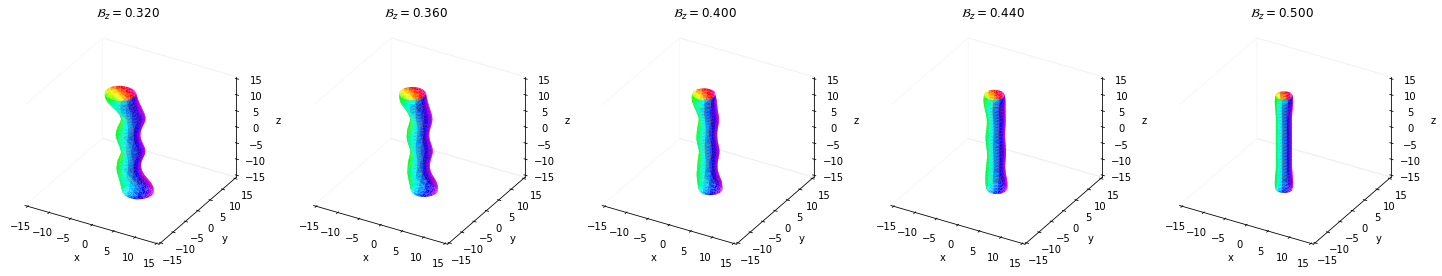

In [29]:
# ax = f.add_subplot(f'13{i + 1}', projection='3d', proj_type = 'ortho')
# ax.set_p

f = plt.figure(figsize=(25, 5))

titles = [320, 360, 400, 440, 500]
for i in range(5):

    # Sk tube surface
    ax = f.add_subplot(1, 5, i + 1, projection='3d', proj_type='ortho')

    vol_mz = spins[i][:, 2].reshape(nx, ny, nz)
    verts, faces, normals, values = measure.marching_cubes(vol_mz.T, 0., 
                                                           spacing=(1, 1, 1))
    verts -= 14.5
    p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                        triangles=faces,
                        # cannot control color point-wise in trisurf:  
                        color='red',
                        # cmap='RdYlBu', 
                        lw=1, vmin=-1, vmax=1
                        )
    # print(p._facecolors3d.shape)
    vol_mx = spins[i][:, 0].reshape(nx, ny, nz).T
    data_interp_x = si.RegularGridInterpolator((xs, ys, zs), vol_mx)
    vol_my = spins[i][:, 1].reshape(nx, ny, nz).T
    data_interp_y = si.RegularGridInterpolator((xs, ys, zs), vol_my)
    vol_mz = spins[i][:, 2].reshape(nx, ny, nz).T
    data_interp_z = si.RegularGridInterpolator((xs, ys, zs), vol_mz)

    tri_centres = np.mean(verts[faces], axis=1)
    # colors = mpl.cm.RdBu(data_interp(tri_centres))
    # print('tcs', tri_centres.shape)
    m_interp = np.column_stack((data_interp_x(tri_centres),
                                data_interp_y(tri_centres),
                                data_interp_z(tri_centres)))
    # print('ms', m_interp.shape)
    colors = ot.generate_colours(m_interp)
    p._facecolors2d = p._facecolors3d
    p.set_facecolors(colors)
    
    ax.set_title(r'$\mathcal{B}_{z}=$' + f'{titles[i] * 1e-3:.3f}')

for ax in f.get_axes():
    ax.set_xlim([-15, 15])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-15, 15])

    # Get rid of colored axes planes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# ----------------------------------------------------------------------------
    
# plt.savefig('sk_tube_Bz400_cuboids_minimisation.pdf', bbox_inches='tight')
plt.savefig('sk_tubes_vs_field_no-anisotropy.jpg', dpi=200,
            bbox_inches='tight')

# Helical (no anisotropy)

In [22]:
spins = []

# ['helix_L10_anisotropy_test/m_helix_L10_anisotropy_test_INITIAL_Bz_000000.npy',
#  'helix_L10_anisotropy_test/m_helix_L10_anisotropy_test_Bz_000000.npy']

SIM_PATH = Path('sims/fidimag/equilibrium_states/D727e-3/npys/')

for s in ['helix_L10_test/m_helix_L10_test_INITIAL_Bz_000000.npy',
          'helix_L10_test/m_helix_L10_test_Bz_000000.npy']:
    sim.set_m(np.load(SIM_PATH / f'{s}'))
    sp_copy = np.copy(sim.spin.reshape(-1, 3))
    spins.append(sp_copy)

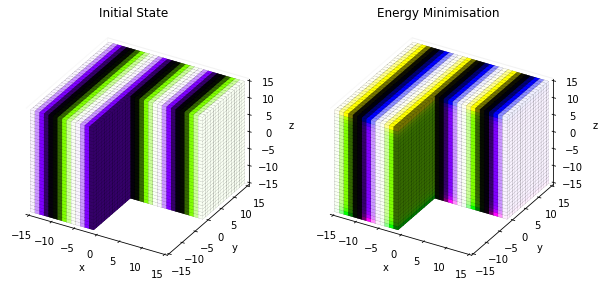

In [24]:
# ax = f.add_subplot(f'13{i + 1}', projection='3d', proj_type = 'ortho')
# ax.set_p

f = plt.figure(figsize=(10, 5))

for i in range(2):
    spin = spins[i]
    ax = f.add_subplot(1, 2, i  + 1, projection='3d', 
                       proj_type='ortho'
                       )
    
    ftr = np.logical_or(y > -1, x < -1)
    ls = LightSource(azdeg=65, altdeg=10)
    m_data = np.column_stack((spin[:, 0][ftr], 
                              spin[:, 1][ftr], 
                              spin[:, 2][ftr]))
    col= pt.plotCubeAt(mesh.coordinates[ftr],
                       np.tile(np.array([1., 1., 1.]), 
                               len(mesh.coordinates[ftr])).reshape(-1, 3),
                       edgecolor="k", linewidth=.05,
                       colors=ot.generate_colours(m_data)
                       # lightsource=True
                       # lightsource=ls
                       )
    ax.add_collection3d(col)
    
    ax.set_xlim([-15, 15])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-15, 15])

    # Get rid of colored axes planes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

titles = ['Initial State', 'Energy Minimisation']
for i in range(2):
    ax = f.get_axes()[i]
    ax.set_title(titles[i])
    
# plt.savefig('helicoid_Bz000_cuboids_minimisation.pdf', bbox_inches='tight')
plt.savefig('helicoid_Bz000_cuboids_minimisation.jpg', dpi=200,
            bbox_inches='tight')

In [86]:
spins = []

HELIX_PATH = Path('sims/fidimag/equilibrium_states/cubic_anisotropy/helix_frankestein_INITIAL/npys/')

for s in ['sk_helix_HYST_weak-tol/m_sk_helix_HYST_weak-tol_INITIAL_Bz_000000.npy',
          'sk_helix_HYST_weak-tol/m_sk_helix_HYST_weak-tol_Bz_000000.npy']:
    sim.set_m(np.load(HELIX_PATH / f'{s}'))
    sp_copy = np.copy(sim.spin.reshape(-1, 3))
    spins.append(sp_copy)

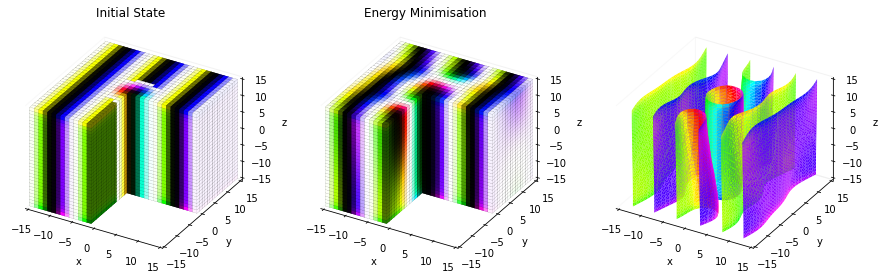

In [87]:
f = plt.figure(figsize=(15, 5))

for i in range(2):
    spin = spins[i]
    ax = f.add_subplot(1, 3, i  + 1, projection='3d', 
                       proj_type='ortho'
                       )
    
    ftr = np.logical_or(y > -1, x < -1)
    ls = LightSource(azdeg=65, altdeg=10)
    m_data = np.column_stack((spin[:, 0][ftr], 
                              spin[:, 1][ftr], 
                              spin[:, 2][ftr]))
    col= pt.plotCubeAt(mesh.coordinates[ftr],
                       np.tile(np.array([1., 1., 1.]), 
                               len(mesh.coordinates[ftr])).reshape(-1, 3),
                       edgecolor="k", linewidth=.05,
                       # facecolor='C0', alpha=0.1,
                       # colors=mpl.cm.RdBu(data_interp(coords[ftr])),
                       # colors=mpl.cm.RdBu(spin[:, 2][ftr]),
                       colors=ot.generate_colours(m_data)
                       # lightsource=True
                       # lightsource=ls
                       )
    ax.add_collection3d(col)
    
# ----------------------------------------------------------------------------
# Sk tube surface
ax = f.add_subplot(1, 3, 3, projection='3d', proj_type='ortho')

i = 1
vol_mz = spins[i][:, 2].reshape(nx, ny, nz)
verts, faces, normals, values = measure.marching_cubes(vol_mz.T, 0., 
                                                       spacing=(1, 1, 1))
verts -= 14.5
p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                    triangles=faces,
                    # cannot control color point-wise in trisurf:  
                    color='red',
                    # cmap='RdYlBu', 
                    lw=1, vmin=-1, vmax=1
                    )
# print(p._facecolors3d.shape)
vol_mx = spins[i][:, 0].reshape(nx, ny, nz).T
data_interp_x = si.RegularGridInterpolator((xs, ys, zs), vol_mx)
vol_my = spins[i][:, 1].reshape(nx, ny, nz).T
data_interp_y = si.RegularGridInterpolator((xs, ys, zs), vol_my)
vol_mz = spins[i][:, 2].reshape(nx, ny, nz).T
data_interp_z = si.RegularGridInterpolator((xs, ys, zs), vol_mz)

tri_centres = np.mean(verts[faces], axis=1)
# colors = mpl.cm.RdBu(data_interp(tri_centres))
# print('tcs', tri_centres.shape)
m_interp = np.column_stack((data_interp_x(tri_centres),
                            data_interp_y(tri_centres),
                            data_interp_z(tri_centres)))
# print('ms', m_interp.shape)
colors = ot.generate_colours(m_interp)
p._facecolors2d = p._facecolors3d
p.set_facecolors(colors)

for ax in f.get_axes():
    ax.set_xlim([-15, 15])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-15, 15])

    # Get rid of colored axes planes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# ----------------------------------------------------------------------------

titles = ['Initial State', 'Energy Minimisation']
for i in range(2):
    ax = f.get_axes()[i]
    ax.set_title(titles[i])
    
# plt.savefig('sk_tube_Bz400_cuboids_minimisation.pdf', bbox_inches='tight')
plt.savefig('sk_helicoid_cuboids_minimisation_zero-field_weak-tolerance.jpg',
            dpi=200, bbox_inches='tight')

## With a stronger tolerance 

In [6]:
spins = []

HELIX_PATH = Path('sims/fidimag/equilibrium_states/cubic_anisotropy/helix_frankestein_INITIAL/npys/')

for s in ['sk_helix_HYST/m_sk_helix_HYST_INITIAL_Bz_000000.npy',
          'sk_helix_HYST/m_sk_helix_HYST_Bz_000000.npy']:
    sim.set_m(np.load(HELIX_PATH / f'{s}'))
    sp_copy = np.copy(sim.spin.reshape(-1, 3))
    spins.append(sp_copy)

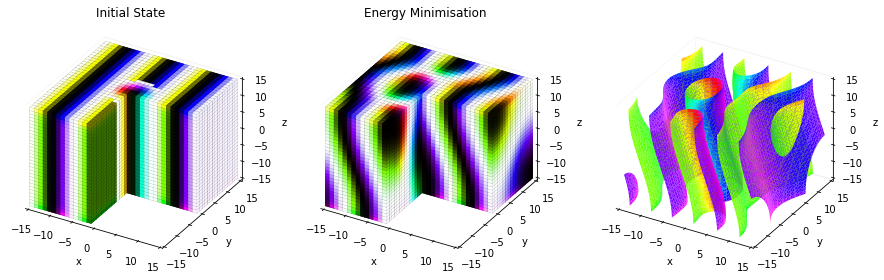

In [7]:
f = plt.figure(figsize=(15, 5))

for i in range(2):
    spin = spins[i]
    ax = f.add_subplot(1, 3, i  + 1, projection='3d', 
                       proj_type='ortho'
                       )
    
    ftr = np.logical_or(y > -1, x < -1)
    ls = LightSource(azdeg=65, altdeg=10)
    m_data = np.column_stack((spin[:, 0][ftr], 
                              spin[:, 1][ftr], 
                              spin[:, 2][ftr]))
    col= pt.plotCubeAt(mesh.coordinates[ftr],
                       np.tile(np.array([1., 1., 1.]), 
                               len(mesh.coordinates[ftr])).reshape(-1, 3),
                       edgecolor="k", linewidth=.05,
                       # facecolor='C0', alpha=0.1,
                       # colors=mpl.cm.RdBu(data_interp(coords[ftr])),
                       # colors=mpl.cm.RdBu(spin[:, 2][ftr]),
                       colors=ot.generate_colours(m_data)
                       # lightsource=True
                       # lightsource=ls
                       )
    ax.add_collection3d(col)
    
# ----------------------------------------------------------------------------
# Sk tube surface
ax = f.add_subplot(1, 3, 3, projection='3d', proj_type='ortho')

i = 1
vol_mz = spins[i][:, 2].reshape(nx, ny, nz)
verts, faces, normals, values = measure.marching_cubes(vol_mz.T, 0., 
                                                       spacing=(1, 1, 1))
verts -= 14.5
p = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], 
                    triangles=faces,
                    # cannot control color point-wise in trisurf:  
                    color='red',
                    # cmap='RdYlBu', 
                    lw=1, vmin=-1, vmax=1
                    )
# print(p._facecolors3d.shape)
vol_mx = spins[i][:, 0].reshape(nx, ny, nz).T
data_interp_x = si.RegularGridInterpolator((xs, ys, zs), vol_mx)
vol_my = spins[i][:, 1].reshape(nx, ny, nz).T
data_interp_y = si.RegularGridInterpolator((xs, ys, zs), vol_my)
vol_mz = spins[i][:, 2].reshape(nx, ny, nz).T
data_interp_z = si.RegularGridInterpolator((xs, ys, zs), vol_mz)

tri_centres = np.mean(verts[faces], axis=1)
# colors = mpl.cm.RdBu(data_interp(tri_centres))
# print('tcs', tri_centres.shape)
m_interp = np.column_stack((data_interp_x(tri_centres),
                            data_interp_y(tri_centres),
                            data_interp_z(tri_centres)))
# print('ms', m_interp.shape)
colors = ot.generate_colours(m_interp)
p._facecolors2d = p._facecolors3d
p.set_facecolors(colors)

for ax in f.get_axes():
    ax.set_xlim([-15, 15])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-15, 15])

    # Get rid of colored axes planes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# ----------------------------------------------------------------------------

titles = ['Initial State', 'Energy Minimisation']
for i in range(2):
    ax = f.get_axes()[i]
    ax.set_title(titles[i])
    
# plt.savefig('sk_tube_Bz400_cuboids_minimisation.pdf', bbox_inches='tight')
plt.savefig('sk_helicoid_cuboids_minimisation_zero-field_strong-tol.jpg', dpi=200,
            bbox_inches='tight')